#COLOR DETECTION SYSTEM

I got the data by searching online on google dataset search.


**About the dataset** :This dataset contains 10 class of color, each color class contains 25 images.

**Link** :https://www.kaggle.com/datasets/adikurniawan/color-dataset-for-color-recognition


**Reading the data**

In [232]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
data_path= "/content/drive/MyDrive/training_dataset/"

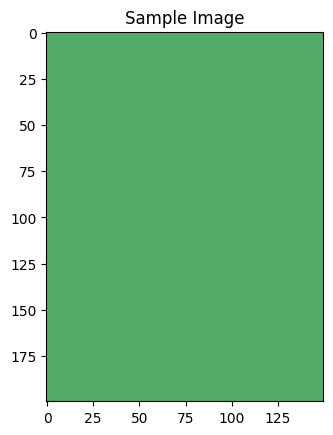

In [235]:

# Get the list of subdirectories in the main directory
subdirectories = [subdir for subdir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, subdir))]

# display the first image from the first subdirectory
sample_subdirectory = subdirectories[0]
sample_image_path = os.path.join(data_path, sample_subdirectory, os.listdir(os.path.join(data_path, sample_subdirectory))[0])

# Read the image using plt.imread
sample_image = plt.imread(sample_image_path)

# Display the image
plt.imshow(sample_image)
plt.grid(False)
plt.title("Sample Image")
plt.show()


#**Data preprocessing**

In [236]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./25)

# Flow from directory to generate batches of augmented images
training_set = datagen.flow_from_directory(
    "/content/drive/MyDrive/training_dataset/",
    target_size=(64, 64),  # Resize images to (64, 64)
    batch_size=32  # Batch size for generating augmented images
)

# Concatenate batches of augmented images to create the training data
training_data = np.concatenate([training_set.next()[0] for i in range(training_set.__len__())])


Found 250 images belonging to 10 classes.


In [237]:
# Initialize lists to store RGB values and corresponding color labels
rgb = []
color = []

# Iterate through directories and files
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        # Construct the full path to the image
        image_path = os.path.join(dirname, filename)

        # Read the image using OpenCV and convert the color to RGB
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

        # Append the RGB value of the first pixel (top-left corner) to the 'rgb' list
        rgb.append(image[0][0])

        # Append the corresponding color label to the 'color' list
        color.append(dirname[40:])


In [238]:
#creating a dataframe of my data
x = pd.DataFrame(np.array(rgb), columns=['red', 'green', 'blue'])
y = pd.DataFrame({'color': color})
print(x)
print(y)

     red  green  blue
0     84    172   104
1    123    252     1
2     51    184   100
3      0    100     0
4    118    181   131
..   ...    ...   ...
245  255    122     1
246  255    103     0
247  255    117    24
248  255     95     0
249  255    127     0

[250 rows x 3 columns]
      color
0     green
1     green
2     green
3     green
4     green
..      ...
245  orange
246  orange
247  orange
248  orange
249  orange

[250 rows x 1 columns]


In [239]:
# Convert lists 'rgb' and 'color' to NumPy arrays
x = np.array(rgb)
y = np.array(color)

# Display the shape of the arrays
print("Shape of x (RGB values):", x.shape)
print("Shape of y (Color labels):", y.shape)


Shape of x (RGB values): (250, 3)
Shape of y (Color labels): (250,)


In [240]:
#Turn the label into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#**Model**

Using KNN is the best suitated for the task because of my approach to the task K-NN algorithm classifies a data point by considering the majority class among its k-nearest neighbors.  I'm using  it because i'm trying to train the model to recognize color based on rgb value therefore it needs to find the closest value.

In [241]:
#Split data into training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [242]:

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


# Use RandomOverSampler to oversample minority classes in the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Create the KNeighborsClassifier with default hyperparameters
knn = KNeighborsClassifier()

# Fit the model to the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.88      0.78      0.82         9
           2       0.80      0.80      0.80         5
           3       1.00      0.50      0.67         8
           4       0.50      1.00      0.67         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       0.88      1.00      0.93         7
           9       1.00      0.67      0.80         3

    accuracy                           0.84        50
   macro avg       0.91      0.87      0.87        50
weighted avg       0.89      0.84      0.84        50



#**Hypertunning of the model**

In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31), 'weights': ['distance'], 'metric': ['euclidean']}

# Create the KNeighborsClassifier
knn = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_

# Create the KNeighborsClassifier with the best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'], metric=best_params['metric'])

# Fit the best model to the data
best_knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Print the best parameters and accuracy
print("Best Parameters:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred))


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Accuracy: 0.9


In [244]:
#using best parameter for the model
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', metric='euclidean')

# Fit the model to the resampled training data
knn.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.78      0.88         9
           2       0.80      0.80      0.80         5
           3       1.00      0.88      0.93         8
           4       0.62      1.00      0.77         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       0.88      1.00      0.93         7
           9       1.00      0.67      0.80         3

    accuracy                           0.90        50
   macro avg       0.93      0.91      0.91        50
weighted avg       0.93      0.90      0.90        50



Accuracy: The overall accuracy of the model is 90%.

Precision: Precision is high for most classes, especially for classes 0, 1, 3, 5, 6, 7, and 9. This means that when the model predicts a certain class, it is often correct.

Recall: Recall measures the model's ability to capture all instances of a particular class. It is high for classes 0, 3, 5, 6, 7, and 8. However, it is lower for class 1 and class 9.

F1-score: The F1-score is high for most classes, with class 0 achieving a perfect score.


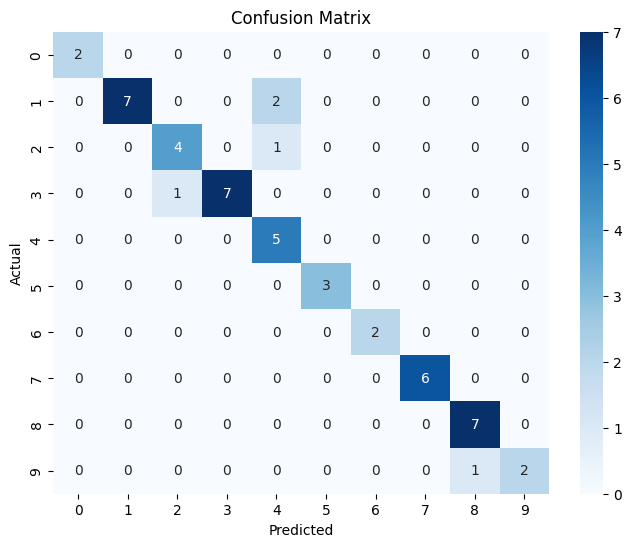

In [245]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [246]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'black': 0, 'blue': 1, 'brown': 2, 'green': 3, 'grey': 4, 'orange': 5, 'red': 6, 'violet': 7, 'white': 8, 'yellow': 9}


The confusion matrix show that the model is able to recognize most colors but can predict falsely on some cases like class 4,2and 8

In [247]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')



MAE: 0.2


MAE of 0.2  suggests that, on average, the model's predictions are quite close to the actual values, and the errors are not very large.

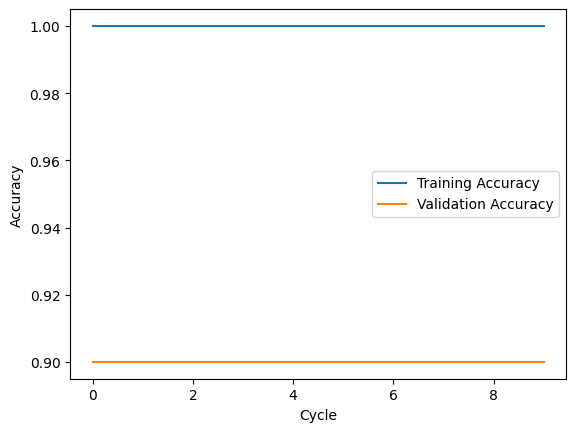

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.78      0.88         9
           2       0.80      0.80      0.80         5
           3       1.00      0.88      0.93         8
           4       0.62      1.00      0.77         5
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         6
           8       0.88      1.00      0.93         7
           9       1.00      0.67      0.80         3

    accuracy                           0.90        50
   macro avg       0.93      0.91      0.91        50
weighted avg       0.93      0.90      0.90        50



In [248]:

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Number of cycles through the dataset (you can choose this value)
num_cycles = 10

for cycle in range(num_cycles):
    # Train the model on the resampled training set
    knn.fit(X_train_resampled, y_train_resampled)

    # Predict on the training set and calculate training accuracy
    y_train_pred = knn.predict(X_train_resampled)
    training_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    training_accuracies.append(training_accuracy)

    # Predict on the validation set and calculate validation accuracy
    y_val_pred = knn.predict(X_test)
    validation_accuracy = accuracy_score(y_test, y_val_pred)
    validation_accuracies.append(validation_accuracy)

    # Optionally, print or log the training and validation accuracies

# Plot the training and validation accuracies over cycles
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Cycle')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Finally, make predictions on the test set and print classification report
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


The learning graph shows that there no apparent overfitting or underfitting in the model.

In [249]:
import pickle


model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(knn, file)



In [250]:
from google.colab import files

files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>